# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc , accuracy_score

In [3]:
file = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
file.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [6]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [9]:
file["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [11]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

file["flight_day"] = file["flight_day"].map(mapping)

In [13]:
file["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [15]:
file.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [18]:
file.shape

(50000, 14)

In [20]:
file.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

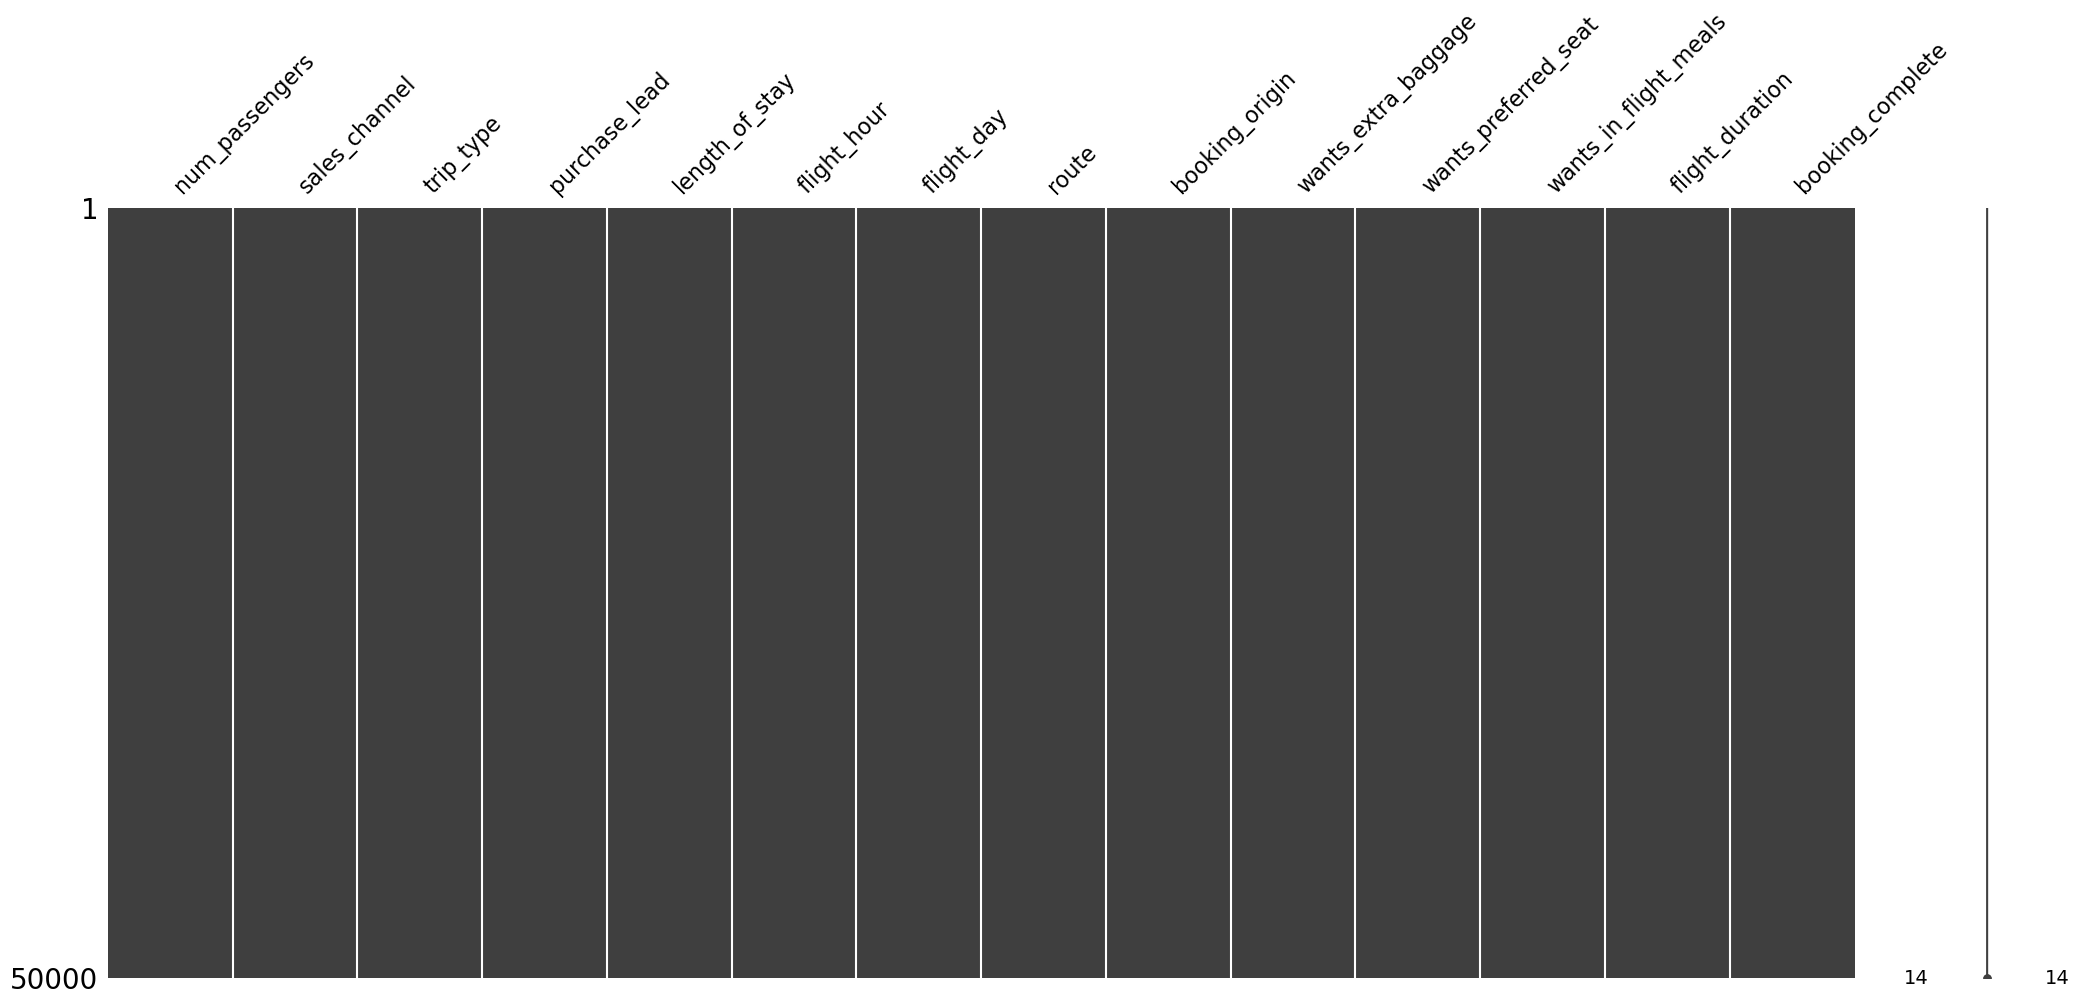

In [22]:
import missingno as msno
msno.matrix(file)
plt.show()

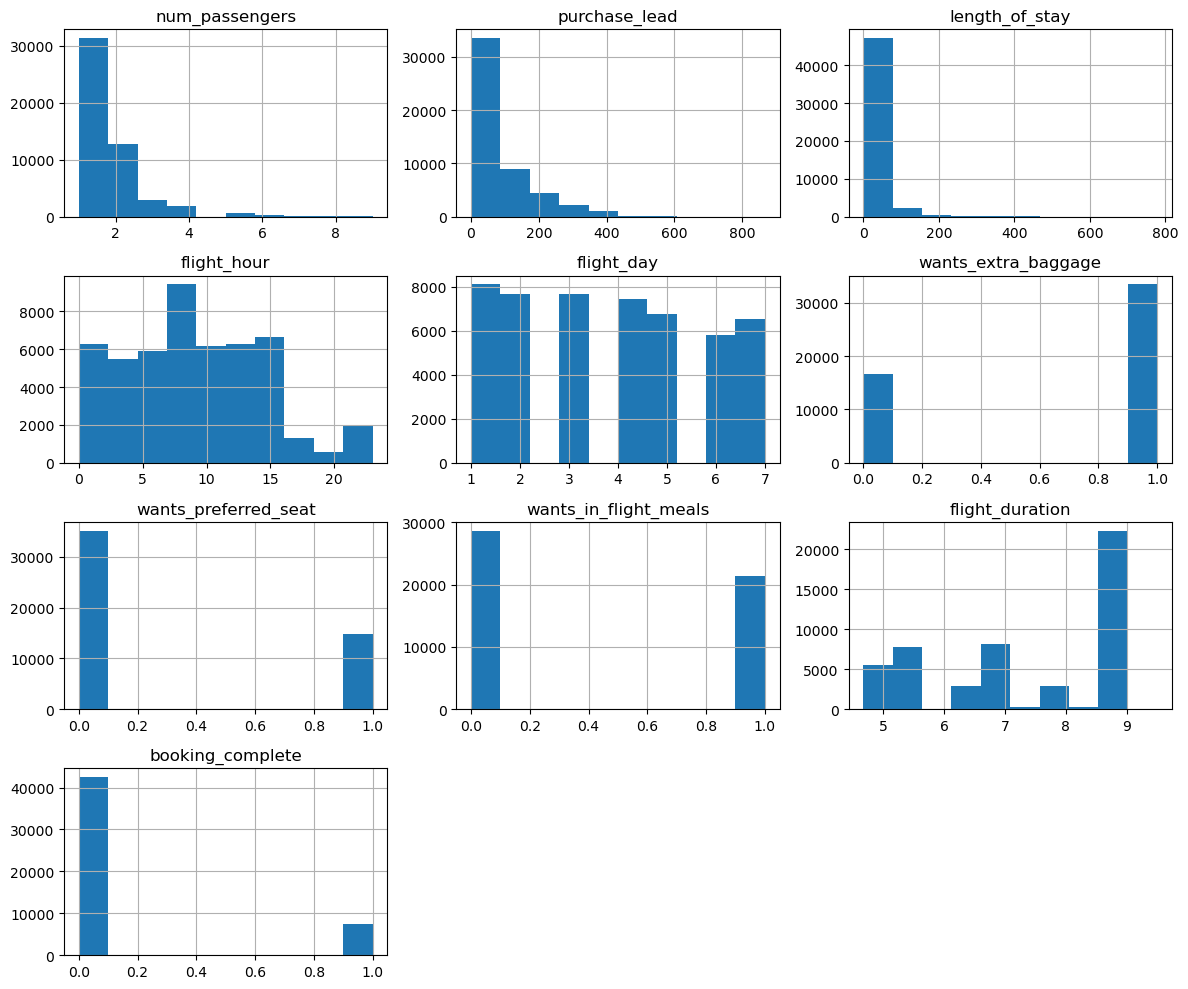

<Axes: xlabel='purchase_lead', ylabel='Count'>

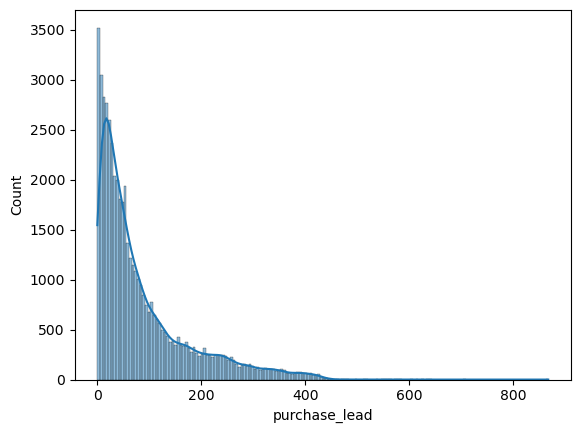

In [23]:
# Plot distributions for numerical columns
file.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# You can also use seaborn to plot specific distributions
sns.histplot(file['purchase_lead'], kde=True)

<Axes: xlabel='sales_channel', ylabel='count'>

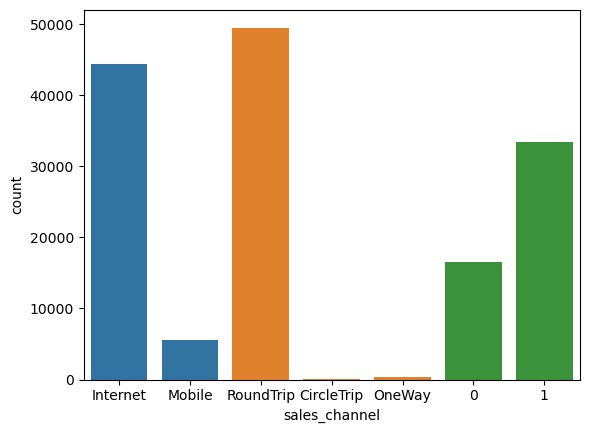

In [27]:
# Plot distribution of categorical variables
sns.countplot(x='sales_channel', data=file)
sns.countplot(x='trip_type', data=file)
sns.countplot(x='wants_extra_baggage', data=file)

In [33]:
# Convert boolean columns to 0 or 1
bool_columns = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
for col in bool_columns:
    file[col] = file[col].astype(int)
    
# Check the updated data types
print(file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int32  
 10  wants_preferred_seat   50000 non-null  int32  
 11  wants_in_flight_meals  50000 non-null  int32  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int32(3), int64(6), object(4)
memory us

In [37]:
X = file.drop('booking_complete', axis=1)
y = file['booking_complete']

In [39]:
# List of categorical and numerical columns
categorical_columns = ['sales_channel', 'trip_type', 'route', 'booking_origin']
numerical_columns = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

In [53]:
# Create a column transformer with OneHotEncoder handling unknown categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
# Create a pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [59]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sales_channel', 'trip_type',
                                                   'route',
                                                   'booking_origin'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [63]:
# Make predictions
y_pred = model.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


In [65]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8442666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     12784
           1       0.43      0.17      0.25      2216

    accuracy                           0.84     15000
   macro avg       0.65      0.57      0.58     15000
weighted avg       0.81      0.84      0.81     15000



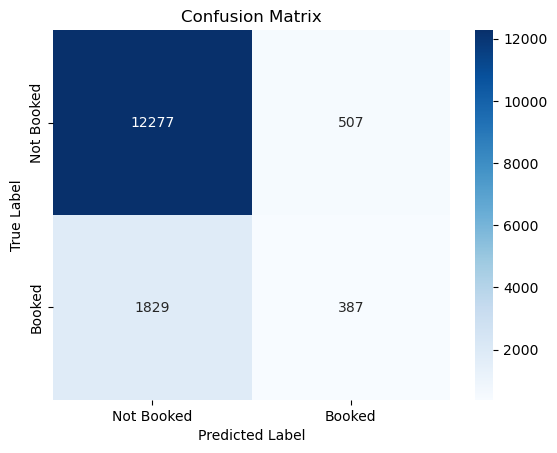

In [67]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Booked", "Booked"], yticklabels=["Not Booked", "Booked"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

* Precision: The proportion of positive predictions that are actually correct.

* Recall: The proportion of actual positives that are correctly identified by the model.

* F1-Score: The harmonic mean of precision and recall, which balances the two.

* ROC AUC: The area under the receiver operating characteristic curve, which is a great metric for evaluating classifiers on imbalanced datasets.

In [78]:
# Calculate the ROC AUC score (using the predicted probabilities)
y_prob = model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class (booked = 1)
roc_auc = roc_auc_score(y_test, y_prob)

In [80]:
# Print the ROC AUC score
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.7607


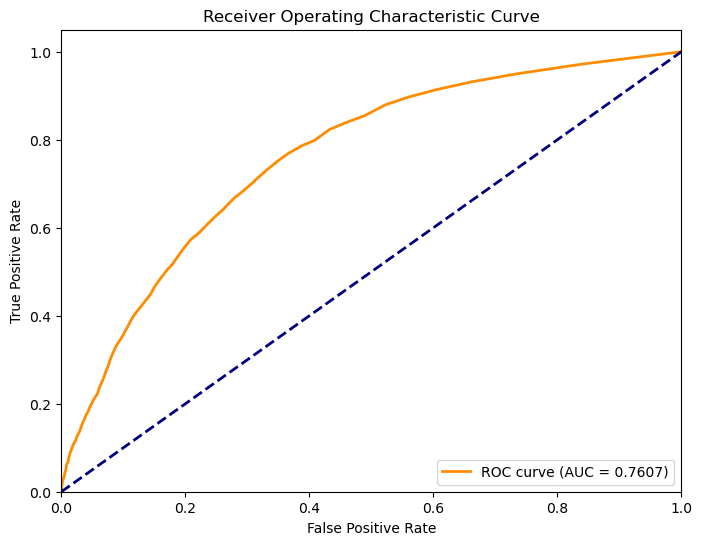

In [82]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [86]:
# Update the pipeline with class weights
model_with_weights = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

In [88]:
# Train the model
model_with_weights.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sales_channel', 'trip_type',
                                                   'route',
                                                   'booking_origin'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [90]:
# Make predictions
y_pred_weighted = model_with_weights.predict(X_test)

In [92]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_weighted))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     12784
           1       0.43      0.16      0.24      2216

    accuracy                           0.84     15000
   macro avg       0.65      0.56      0.57     15000
weighted avg       0.80      0.84      0.81     15000



In [94]:
# Calculate ROC AUC score (using the predicted probabilities)
y_prob_weighted = model_with_weights.predict_proba(X_test)[:, 1]  # Get the probability of the positive class (booked = 1)
roc_auc_weighted = roc_auc_score(y_test, y_prob_weighted)
print(f"ROC AUC (with class weights): {roc_auc_weighted:.4f}")

ROC AUC (with class weights): 0.7625


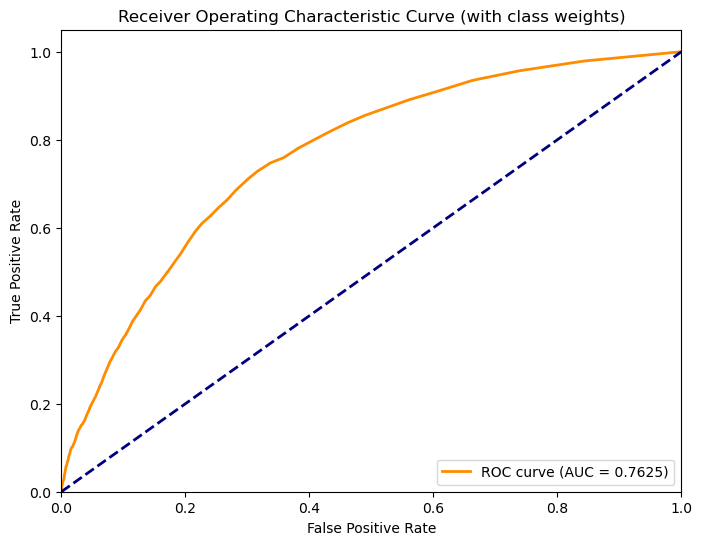

In [96]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_weighted)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_weighted:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (with class weights)')
plt.legend(loc="lower right")
plt.show()

Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     12784
           1       0.38      0.29      0.33      2216

    accuracy                           0.82     15000
   macro avg       0.63      0.61      0.61     15000
weighted avg       0.81      0.82      0.81     15000

ROC AUC (with SMOTE): 0.7618


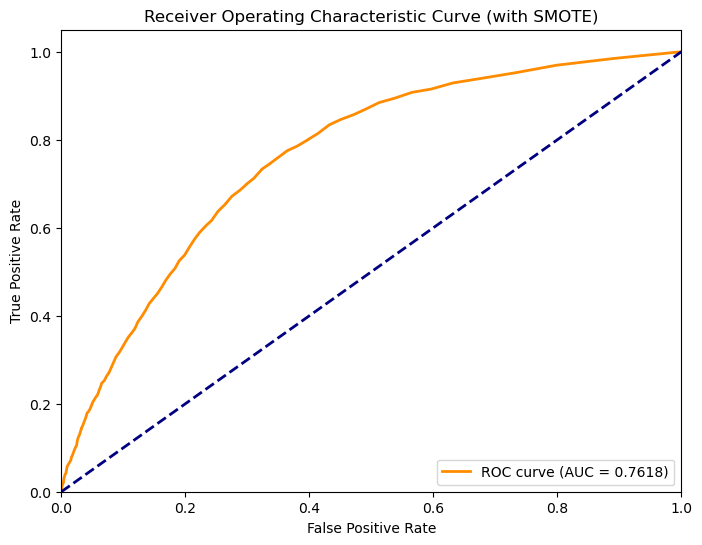

In [102]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Apply SMOTE to balance the class distribution
smote = SMOTE(random_state=42)

# Create a pipeline with SMOTE and the classifier
model_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
model_smote.fit(X_train, y_train)

# Make predictions
y_pred_smote = model_smote.predict(X_test)

# Print Classification Report
print("Classification Report (with SMOTE):")
print(classification_report(y_test, y_pred_smote))

# Calculate ROC AUC score (using the predicted probabilities)
y_prob_smote = model_smote.predict_proba(X_test)[:, 1]  # Get the probability of the positive class (booked = 1)
roc_auc_smote = roc_auc_score(y_test, y_prob_smote)

# Print the ROC AUC score
print(f"ROC AUC (with SMOTE): {roc_auc_smote:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_smote)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_smote:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (with SMOTE)')
plt.legend(loc="lower right")
plt.show()


It looks like the ROC AUC score with SMOTE (0.7618) is quite similar to the previous score with class weights (0.7625), which suggests that SMOTE might not have provided a significant improvement in this case. However, it's important to note that SMOTE may help in other metrics, especially precision and recall for the minority class.

In [105]:
import pickle

# Assuming you have your trained model as `model_smote`
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(model_smote, f)